In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from Environment import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
'''
Direction mapping:
0: left = [-1, 0]
1: right = [1, 0]
2: up = [0, -1]
3: down = [0, 1]
'''

class User_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (4,))    #curr_x, curr_y, target_x, target_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(16, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(4)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])
        
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    

    def play_one_step(self, env, state, mod_agent):
        action_user = self.exp_policy(state)
        action_user_one_hot = make_one_hot(action_user, 4)
        curr_loc = state[:2]
        target_loc = state[2:]
        action_user_one_hot.extend(curr_loc)
        mod_state = action_user_one_hot[:]
        mod_state = np.array(mod_state)
        new_loc, reward, done = mod_agent.play_one_step(env, mod_state, curr_loc, target_loc, self)
        next_state = [new_loc[0], new_loc[1], target_loc[0], target_loc[1]]
        self.replay_buffer.append(state, action_user, reward, next_state, done)
        
        return next_state, reward, done
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.target_model(next_states)
        max_next_Q_values = np.max(next_Q_values, axis= 1)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [3]:
class Mod_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (6,))   #direction of motion_one_hot(4), curr_x, curr_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(16, activation = 'relu')(x)
        x = Dense(4)(x) #modulate by 1,2,3,4 
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.steps_per_epoch = 1
        self.gamma = 0.9
    
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(1,5)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])+1
        
        
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def play_one_step(self, env, state, curr_loc, target_loc, user_agent):
        #Agent not aware of target location
        action_mod = self.exp_policy(state)
        action_user = np.argmax(state[:4])
        action_mod = 1
        new_loc, reward, done = env.step(action_user, action_mod, target_loc, curr_loc)
        next_dir = user_agent.exp_policy(np.array([new_loc[0], new_loc[1], target_loc[0], target_loc[1]]))
        
        next_dir_one_hot = make_one_hot(next_dir, 4)
        next_dir_one_hot.extend(new_loc)
        next_state = next_dir_one_hot[:]
        next_state = np.array(next_state)
        
        self.replay_buffer.append(state, action_mod-1, reward, next_state, done)
        
        
        return new_loc, reward, done
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.target_model(next_states)
        max_next_Q_values = np.max(next_Q_values, axis= 1)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
            

In [4]:
env = Environment()
user_agent = User_Agent()
mod_agent = Mod_Agent()

Icon Locations:
[[0.1 0.9]
 [0.6 0.4]
 [0.3 0.4]
 [0.5 0.4]
 [0.1 0.5]
 [0.7 0.2]]
Icon usage Probabilities
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 756
Trainable params: 756
Non-trainable params: 0
_________________________________________________________________
None
Model: "functional_3"
___________________________________________________

  0%|▏                                                                             | 25/10000 [00:00<00:41, 242.05it/s]

Mean Reward = 13.0
1
Mean Reward = -1.9
1
Mean Reward = -2.0
1
Mean Reward = -2.6
0
Mean Reward = -3.8

  0%|▍                                                                             | 49/10000 [00:00<00:43, 227.12it/s]


0
Mean Reward = -3.4
0


  1%|▌                                                                              | 71/10000 [00:00<01:44, 94.59it/s]

Mean Reward = -1.6
0
Mean Reward = -3.9
2
Updated Weights

  1%|▋                                                                              | 89/10000 [00:00<02:02, 81.23it/s]


Mean Reward = -2.3
1
Mean Reward = -3.0

  1%|▊                                                                              | 97/10000 [00:00<02:04, 79.23it/s]


0
Updated Weights
Mean Reward = -1.6
1


  1%|▉                                                                             | 119/10000 [00:01<03:12, 51.39it/s]

Mean Reward = -6.4
0


  1%|▉                                                                             | 125/10000 [00:01<03:44, 43.98it/s]

Mean Reward = -5.0
0
Updated Weights


  1%|█                                                                             | 135/10000 [00:01<04:00, 41.09it/s]

Mean Reward = -5.3
1


  1%|█▏                                                                            | 145/10000 [00:02<04:23, 37.38it/s]

Mean Reward = -4.4
1


  2%|█▏                                                                            | 157/10000 [00:02<05:06, 32.13it/s]

Updated Weights
Mean Reward = -4.6
0


  2%|█▎                                                                            | 165/10000 [00:02<05:55, 27.66it/s]

Mean Reward = -7.2
0


  2%|█▎                                                                            | 174/10000 [00:03<06:44, 24.31it/s]

Mean Reward = 0.4
1
Updated Weights

  2%|█▍                                                                            | 181/10000 [00:03<06:11, 26.45it/s]


Mean Reward = 1.1
1


  2%|█▌                                                                            | 193/10000 [00:04<06:15, 26.10it/s]

Mean Reward = 1.0
1


  2%|█▌                                                                            | 205/10000 [00:04<06:33, 24.87it/s]

Updated Weights
Mean Reward = -0.7
1


  2%|█▋                                                                            | 214/10000 [00:05<08:14, 19.78it/s]

Mean Reward = -3.7
1


  2%|█▋                                                                            | 223/10000 [00:05<08:03, 20.23it/s]

Mean Reward = 1.4
2


  2%|█▊                                                                            | 229/10000 [00:05<07:29, 21.75it/s]

Updated Weights


  2%|█▊                                                                            | 235/10000 [00:06<07:47, 20.90it/s]

Mean Reward = -2.6
2


  2%|█▉                                                                            | 244/10000 [00:06<07:54, 20.57it/s]

Mean Reward = -2.4
1


  3%|█▉                                                                            | 253/10000 [00:06<07:52, 20.62it/s]

Updated Weights
Mean Reward = 1.2
2


  3%|██                                                                            | 264/10000 [00:07<09:07, 17.77it/s]

Mean Reward = -2.0
0


  3%|██                                                                            | 271/10000 [00:07<08:15, 19.63it/s]

Mean Reward = 3.3
2


  3%|██▏                                                                           | 279/10000 [00:08<08:38, 18.75it/s]

Updated Weights


  3%|██▏                                                                           | 283/10000 [00:08<08:41, 18.63it/s]

Mean Reward = 0.4
1


  3%|██▎                                                                           | 293/10000 [00:09<09:13, 17.54it/s]

Mean Reward = -5.0
0


  3%|██▎                                                                           | 303/10000 [00:09<10:27, 15.44it/s]

Updated Weights
Mean Reward = -3.0
0


  3%|██▍                                                                           | 313/10000 [00:10<10:23, 15.53it/s]

Mean Reward = -2.2
0


  3%|██▌                                                                           | 323/10000 [00:11<10:44, 15.02it/s]

Mean Reward = 0.2
0


  3%|██▌                                                                           | 328/10000 [00:11<08:40, 18.58it/s]

Updated Weights


  3%|██▌                                                                           | 333/10000 [00:11<09:16, 17.38it/s]

Mean Reward = 5.6
5


  3%|██▋                                                                           | 343/10000 [00:12<11:15, 14.29it/s]

Mean Reward = 0.8
0


  4%|██▊                                                                           | 353/10000 [00:13<11:03, 14.54it/s]

Updated Weights
Mean Reward = -5.0
0


  4%|██▊                                                                           | 362/10000 [00:13<11:00, 14.60it/s]

Mean Reward = -1.9
1


  4%|██▉                                                                           | 372/10000 [00:14<12:25, 12.91it/s]

Mean Reward = -4.1
1


  4%|██▉                                                                           | 378/10000 [00:14<12:41, 12.63it/s]

Updated Weights


  4%|██▉                                                                           | 382/10000 [00:15<13:01, 12.30it/s]

Mean Reward = -6.4
0


  4%|███                                                                           | 393/10000 [00:16<11:39, 13.73it/s]

Mean Reward = -5.6
1


  4%|███▏                                                                          | 401/10000 [00:16<13:00, 12.31it/s]

Updated Weights
Mean Reward = -10.6
0


  4%|███▏                                                                          | 413/10000 [00:17<13:50, 11.54it/s]

Mean Reward = -8.5
1


  4%|███▎                                                                          | 423/10000 [00:18<11:38, 13.70it/s]

Mean Reward = -9.4
0


  4%|███▎                                                                          | 427/10000 [00:18<12:31, 12.74it/s]

Updated Weights


  4%|███▎                                                                          | 432/10000 [00:19<11:35, 13.75it/s]

Mean Reward = 1.8
2


  4%|███▍                                                                          | 442/10000 [00:19<12:55, 12.32it/s]

Mean Reward = -2.6
0


  5%|███▌                                                                          | 452/10000 [00:20<12:42, 12.53it/s]

Updated Weights
Mean Reward = -1.0
0


  5%|███▌                                                                          | 462/10000 [00:21<12:12, 13.02it/s]

Mean Reward = -0.4
1


  5%|███▋                                                                          | 472/10000 [00:22<12:13, 13.00it/s]

Mean Reward = -2.0
0


  5%|███▋                                                                          | 478/10000 [00:22<12:18, 12.89it/s]

Updated Weights


  5%|███▊                                                                          | 482/10000 [00:23<13:31, 11.73it/s]

Mean Reward = -1.0
0


  5%|███▊                                                                          | 492/10000 [00:23<12:49, 12.35it/s]

Mean Reward = 2.0
0


  5%|███▉                                                                          | 500/10000 [00:24<13:16, 11.93it/s]

Updated Weights
Mean Reward = 0.0
0


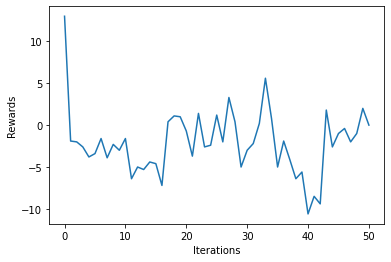

  5%|███▉                                                                          | 512/10000 [00:25<14:37, 10.81it/s]

Mean Reward = -1.2
0


  5%|████                                                                          | 522/10000 [00:26<13:24, 11.78it/s]

Mean Reward = -0.4
0


  5%|████                                                                          | 528/10000 [00:27<12:22, 12.76it/s]

Updated Weights


  5%|████▏                                                                         | 532/10000 [00:27<11:27, 13.76it/s]

Mean Reward = 0.8
2


  5%|████▏                                                                         | 542/10000 [00:28<11:47, 13.36it/s]

Mean Reward = 3.0
2


  6%|████▎                                                                         | 552/10000 [00:29<12:38, 12.45it/s]

Updated Weights
Mean Reward = 2.7
1


  6%|████▍                                                                         | 562/10000 [00:29<13:20, 11.79it/s]

Mean Reward = 1.4
0


  6%|████▍                                                                         | 572/10000 [00:30<14:06, 11.14it/s]

Mean Reward = 1.4
0


  6%|████▌                                                                         | 578/10000 [00:31<13:40, 11.48it/s]

Updated Weights


  6%|████▌                                                                         | 582/10000 [00:31<14:12, 11.05it/s]

Mean Reward = 0.2
0


  6%|████▌                                                                         | 592/10000 [00:32<14:56, 10.49it/s]

Mean Reward = 1.8
0


  6%|████▋                                                                         | 602/10000 [00:33<18:38,  8.40it/s]

Updated Weights
Mean Reward = 2.4
1


  6%|████▊                                                                         | 612/10000 [00:34<15:38, 10.00it/s]

Mean Reward = 1.2
1


  6%|████▊                                                                         | 623/10000 [00:35<15:39,  9.98it/s]

Mean Reward = 0.2
0


  6%|████▉                                                                         | 627/10000 [00:36<14:37, 10.68it/s]

Updated Weights


  6%|████▉                                                                         | 633/10000 [00:36<14:49, 10.54it/s]

Mean Reward = 1.8
1


  6%|█████                                                                         | 643/10000 [00:37<13:04, 11.93it/s]

Mean Reward = 0.4
1


  7%|█████                                                                         | 654/10000 [00:38<12:58, 12.00it/s]

Updated Weights
Mean Reward = -1.4
2


  7%|█████▏                                                                        | 662/10000 [00:39<14:28, 10.75it/s]

Mean Reward = -4.5
1


  7%|█████▎                                                                        | 674/10000 [00:40<12:07, 12.81it/s]

Mean Reward = -2.7
1


  7%|█████▎                                                                        | 678/10000 [00:40<11:39, 13.32it/s]

Updated Weights


  7%|█████▎                                                                        | 682/10000 [00:41<13:53, 11.17it/s]

Mean Reward = 5.3
4


  7%|█████▍                                                                        | 692/10000 [00:41<13:26, 11.55it/s]

Mean Reward = 3.9
2


  7%|█████▍                                                                        | 702/10000 [00:42<13:23, 11.57it/s]

Updated Weights
Mean Reward = 4.3
2


  7%|█████▌                                                                        | 712/10000 [00:43<18:17,  8.46it/s]

Mean Reward = 2.2
1


  7%|█████▋                                                                        | 722/10000 [00:45<18:20,  8.43it/s]

Mean Reward = -3.2
0


  7%|█████▋                                                                        | 727/10000 [00:45<18:52,  8.19it/s]

Updated Weights


  7%|█████▋                                                                        | 731/10000 [00:46<16:57,  9.11it/s]

Mean Reward = 0.0
0


  7%|█████▊                                                                        | 742/10000 [00:47<15:12, 10.15it/s]

Mean Reward = 3.6
1


  8%|█████▊                                                                        | 752/10000 [00:48<14:14, 10.82it/s]

Updated Weights
Mean Reward = 3.3
1


  8%|█████▉                                                                        | 762/10000 [00:49<15:04, 10.22it/s]

Mean Reward = 2.0
0


  8%|██████                                                                        | 772/10000 [00:50<15:14, 10.09it/s]

Mean Reward = 2.3
1


  8%|██████                                                                        | 776/10000 [00:50<13:45, 11.17it/s]

Updated Weights


  8%|██████                                                                        | 782/10000 [00:51<15:00, 10.23it/s]

Mean Reward = 2.2
1


  8%|██████▏                                                                       | 792/10000 [00:52<15:13, 10.08it/s]

Mean Reward = 0.8
0


  8%|██████▎                                                                       | 802/10000 [00:53<17:15,  8.88it/s]

Updated Weights
Mean Reward = 1.0
0


  8%|██████▎                                                                       | 812/10000 [00:54<16:31,  9.27it/s]

Mean Reward = -0.2
0


  8%|██████▍                                                                       | 821/10000 [00:55<15:39,  9.77it/s]

Mean Reward = -0.4
0


  8%|██████▍                                                                       | 827/10000 [00:55<18:08,  8.42it/s]

Updated Weights


  8%|██████▍                                                                       | 832/10000 [00:56<19:07,  7.99it/s]

Mean Reward = 2.4
0


  8%|██████▌                                                                       | 842/10000 [00:57<16:45,  9.11it/s]

Mean Reward = 0.6
0


  9%|██████▋                                                                       | 852/10000 [00:58<16:29,  9.24it/s]

Updated Weights
Mean Reward = 1.2
0


  9%|██████▋                                                                       | 862/10000 [00:59<15:39,  9.73it/s]

Mean Reward = 2.4
0


  9%|██████▊                                                                       | 872/10000 [01:00<16:58,  8.97it/s]

Mean Reward = 2.6
0


  9%|██████▊                                                                       | 877/10000 [01:01<15:53,  9.56it/s]

Updated Weights


  9%|██████▉                                                                       | 882/10000 [01:01<16:43,  9.09it/s]

Mean Reward = -1.4
0


  9%|██████▉                                                                       | 892/10000 [01:02<16:13,  9.36it/s]

Mean Reward = 2.0
1


  9%|███████                                                                       | 902/10000 [01:04<20:42,  7.32it/s]

Updated Weights
Mean Reward = -1.0
0


  9%|███████                                                                       | 912/10000 [01:05<20:29,  7.39it/s]

Mean Reward = 1.8
0


  9%|███████▏                                                                      | 922/10000 [01:06<18:05,  8.37it/s]

Mean Reward = 2.4
1


  9%|███████▏                                                                      | 927/10000 [01:07<19:57,  7.57it/s]

Updated Weights


  9%|███████▎                                                                      | 932/10000 [01:07<16:45,  9.02it/s]

Mean Reward = 3.0
1


  9%|███████▎                                                                      | 942/10000 [01:09<19:49,  7.61it/s]

Mean Reward = 2.6
1


 10%|███████▍                                                                      | 952/10000 [01:10<19:10,  7.86it/s]

Updated Weights
Mean Reward = 1.9
1


 10%|███████▌                                                                      | 962/10000 [01:11<19:48,  7.61it/s]

Mean Reward = 2.3
1


 10%|███████▌                                                                      | 972/10000 [01:12<17:59,  8.36it/s]

Mean Reward = 2.8
1


 10%|███████▌                                                                      | 977/10000 [01:13<20:09,  7.46it/s]

Updated Weights


 10%|███████▋                                                                      | 982/10000 [01:14<17:39,  8.51it/s]

Mean Reward = 3.7
1


 10%|███████▋                                                                      | 992/10000 [01:15<17:11,  8.74it/s]

Mean Reward = 0.6
0


 10%|███████▋                                                                     | 1000/10000 [01:16<17:02,  8.80it/s]

Updated Weights
Mean Reward = 1.9
1


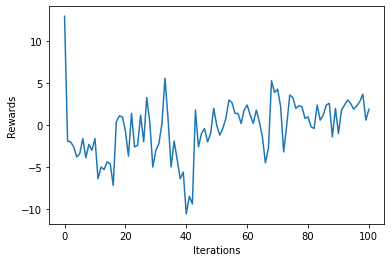

 10%|███████▊                                                                     | 1012/10000 [01:17<17:49,  8.40it/s]

Mean Reward = 1.4
0


 10%|███████▊                                                                     | 1022/10000 [01:18<17:28,  8.56it/s]

Mean Reward = 1.4
0


 10%|███████▉                                                                     | 1027/10000 [01:19<17:23,  8.60it/s]

Updated Weights


 10%|███████▉                                                                     | 1032/10000 [01:20<17:29,  8.55it/s]

Mean Reward = 1.2
0


 10%|████████                                                                     | 1042/10000 [01:21<16:57,  8.80it/s]

Mean Reward = 3.2
0


 11%|████████                                                                     | 1052/10000 [01:22<18:07,  8.23it/s]

Updated Weights
Mean Reward = 1.2
0


 11%|████████▏                                                                    | 1062/10000 [01:23<17:26,  8.54it/s]

Mean Reward = 2.8
1


 11%|████████▎                                                                    | 1072/10000 [01:24<17:29,  8.50it/s]

Mean Reward = 2.0
0


 11%|████████▎                                                                    | 1077/10000 [01:25<17:20,  8.57it/s]

Updated Weights


 11%|████████▎                                                                    | 1082/10000 [01:25<17:43,  8.39it/s]

Mean Reward = 2.2
0


 11%|████████▍                                                                    | 1092/10000 [01:27<17:44,  8.37it/s]

Mean Reward = 2.0
0


 11%|████████▍                                                                    | 1102/10000 [01:28<17:08,  8.65it/s]

Updated Weights
Mean Reward = 2.4
0


 11%|████████▌                                                                    | 1112/10000 [01:29<17:45,  8.34it/s]

Mean Reward = 1.0
0


 11%|████████▋                                                                    | 1122/10000 [01:30<16:25,  9.00it/s]

Mean Reward = 3.2
1


 11%|████████▋                                                                    | 1127/10000 [01:31<17:39,  8.38it/s]

Updated Weights


 11%|████████▋                                                                    | 1132/10000 [01:31<17:41,  8.35it/s]

Mean Reward = 2.0
0


 11%|████████▊                                                                    | 1142/10000 [01:32<15:28,  9.54it/s]

Mean Reward = 1.9
2


 12%|████████▊                                                                    | 1152/10000 [01:33<18:20,  8.04it/s]

Updated Weights
Mean Reward = 0.8
0


 12%|████████▉                                                                    | 1162/10000 [01:35<19:20,  7.62it/s]

Mean Reward = 3.0
0


 12%|█████████                                                                    | 1172/10000 [01:36<18:21,  8.02it/s]

Mean Reward = 3.2
0


 12%|█████████                                                                    | 1177/10000 [01:37<19:10,  7.67it/s]

Updated Weights


 12%|█████████                                                                    | 1181/10000 [01:37<18:13,  8.07it/s]

Mean Reward = 0.6
0


 12%|█████████▏                                                                   | 1192/10000 [01:38<18:30,  7.93it/s]

Mean Reward = 5.1
2


 12%|█████████▎                                                                   | 1202/10000 [01:40<18:09,  8.07it/s]

Updated Weights
Mean Reward = 1.8
0


 12%|█████████▎                                                                   | 1212/10000 [01:41<17:16,  8.48it/s]

Mean Reward = 3.8
0


 12%|█████████▍                                                                   | 1222/10000 [01:42<18:56,  7.73it/s]

Mean Reward = 3.0
0


 12%|█████████▍                                                                   | 1227/10000 [01:43<17:25,  8.39it/s]

Updated Weights


 12%|█████████▍                                                                   | 1232/10000 [01:43<16:55,  8.63it/s]

Mean Reward = 2.4
0


 12%|█████████▌                                                                   | 1242/10000 [01:44<17:24,  8.38it/s]

Mean Reward = 4.2
0


 13%|█████████▋                                                                   | 1252/10000 [01:46<18:55,  7.70it/s]

Updated Weights
Mean Reward = 2.4
0


 13%|█████████▋                                                                   | 1262/10000 [01:47<17:15,  8.43it/s]

Mean Reward = 2.2
0


 13%|█████████▊                                                                   | 1272/10000 [01:48<17:54,  8.12it/s]

Mean Reward = 2.0
0


 13%|█████████▊                                                                   | 1277/10000 [01:49<18:44,  7.75it/s]

Updated Weights


 13%|█████████▊                                                                   | 1282/10000 [01:49<17:06,  8.49it/s]

Mean Reward = 3.8
1


 13%|█████████▉                                                                   | 1291/10000 [01:50<18:58,  7.65it/s]

Mean Reward = 1.0
0


 13%|██████████                                                                   | 1302/10000 [01:52<22:03,  6.57it/s]

Updated Weights
Mean Reward = 3.5
1


 13%|██████████                                                                   | 1312/10000 [01:53<20:23,  7.10it/s]

Mean Reward = 2.2
0


 13%|██████████▏                                                                  | 1322/10000 [01:55<17:58,  8.04it/s]

Mean Reward = 3.8
1


 13%|██████████▏                                                                  | 1328/10000 [01:55<15:28,  9.34it/s]

Updated Weights


 13%|██████████▎                                                                  | 1332/10000 [01:56<16:53,  8.56it/s]

Mean Reward = 4.1
1


 13%|██████████▎                                                                  | 1342/10000 [01:57<19:22,  7.45it/s]

Mean Reward = 1.2
0


 14%|██████████▍                                                                  | 1352/10000 [01:58<17:26,  8.27it/s]

Updated Weights
Mean Reward = 4.4
1


 14%|██████████▍                                                                  | 1362/10000 [02:00<19:19,  7.45it/s]

Mean Reward = 4.5
1


 14%|██████████▌                                                                  | 1372/10000 [02:01<18:34,  7.74it/s]

Mean Reward = 4.4
1


 14%|██████████▌                                                                  | 1377/10000 [02:02<18:19,  7.84it/s]

Updated Weights


 14%|██████████▋                                                                  | 1382/10000 [02:02<18:42,  7.68it/s]

Mean Reward = 2.2
0


 14%|██████████▋                                                                  | 1393/10000 [02:03<15:28,  9.27it/s]

Mean Reward = 3.0
0


 14%|██████████▊                                                                  | 1401/10000 [02:04<17:47,  8.06it/s]

Updated Weights
Mean Reward = 6.3
1


 14%|██████████▊                                                                  | 1412/10000 [02:06<21:18,  6.72it/s]

Mean Reward = 4.0
0


 14%|██████████▉                                                                  | 1422/10000 [02:07<17:13,  8.30it/s]

Mean Reward = 4.0
0


 14%|██████████▉                                                                  | 1427/10000 [02:08<23:13,  6.15it/s]

Updated Weights


 14%|███████████                                                                  | 1432/10000 [02:09<23:13,  6.15it/s]

Mean Reward = 3.6
0


 14%|███████████                                                                  | 1443/10000 [02:10<15:45,  9.05it/s]

Mean Reward = 1.6
0


 15%|███████████▏                                                                 | 1452/10000 [02:11<18:06,  7.87it/s]

Updated Weights
Mean Reward = 5.7
2


 15%|███████████▎                                                                 | 1462/10000 [02:12<15:57,  8.91it/s]

Mean Reward = 2.6
1


 15%|███████████▎                                                                 | 1472/10000 [02:14<18:43,  7.59it/s]

Mean Reward = 2.2
0


 15%|███████████▎                                                                 | 1477/10000 [02:14<17:08,  8.29it/s]

Updated Weights


 15%|███████████▍                                                                 | 1482/10000 [02:15<17:22,  8.17it/s]

Mean Reward = 4.5
1


 15%|███████████▍                                                                 | 1492/10000 [02:16<17:59,  7.88it/s]

Mean Reward = 5.1
2


 15%|███████████▌                                                                 | 1500/10000 [02:17<17:44,  7.98it/s]

Updated Weights
Mean Reward = 2.6
0


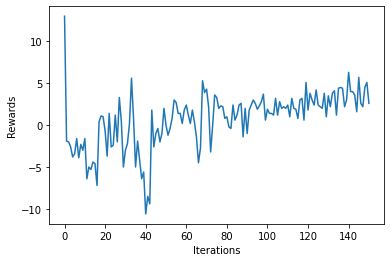

 15%|███████████▋                                                                 | 1513/10000 [02:19<16:17,  8.68it/s]

Mean Reward = 3.6
0


 15%|███████████▋                                                                 | 1522/10000 [02:20<17:43,  7.97it/s]

Mean Reward = 5.0
3


 15%|███████████▊                                                                 | 1527/10000 [02:21<17:06,  8.26it/s]

Updated Weights


 15%|███████████▊                                                                 | 1532/10000 [02:21<17:10,  8.22it/s]

Mean Reward = 3.2
0


 15%|███████████▊                                                                 | 1542/10000 [02:22<17:23,  8.11it/s]

Mean Reward = 5.2
2


 16%|███████████▉                                                                 | 1552/10000 [02:24<18:14,  7.72it/s]

Updated Weights
Mean Reward = 3.0
0


 16%|████████████                                                                 | 1562/10000 [02:25<17:33,  8.01it/s]

Mean Reward = 5.0
0


 16%|████████████                                                                 | 1572/10000 [02:26<17:08,  8.19it/s]

Mean Reward = 4.5
1


 16%|████████████▏                                                                | 1577/10000 [02:27<17:44,  7.91it/s]

Updated Weights


 16%|████████████▏                                                                | 1582/10000 [02:27<17:16,  8.12it/s]

Mean Reward = 2.2
0


 16%|████████████▎                                                                | 1592/10000 [02:28<16:46,  8.35it/s]

Mean Reward = 4.9
1


 16%|████████████▎                                                                | 1602/10000 [02:29<14:38,  9.56it/s]

Updated Weights
Mean Reward = 7.4
4


 16%|████████████▍                                                                | 1612/10000 [02:31<20:10,  6.93it/s]

Mean Reward = 3.0
0


 16%|████████████▍                                                                | 1620/10000 [02:32<23:11,  6.02it/s]

Mean Reward = 6.2
2


 16%|████████████▌                                                                | 1627/10000 [02:33<17:49,  7.83it/s]

Updated Weights


 16%|████████████▌                                                                | 1632/10000 [02:33<17:04,  8.17it/s]

Mean Reward = 5.2
2


 16%|████████████▋                                                                | 1642/10000 [02:34<17:05,  8.15it/s]

Mean Reward = 3.9
1


 17%|████████████▋                                                                | 1652/10000 [02:36<17:50,  7.80it/s]

Updated Weights
Mean Reward = 2.0
0


 17%|████████████▊                                                                | 1662/10000 [02:37<17:13,  8.07it/s]

Mean Reward = 0.6
0


 17%|████████████▉                                                                | 1673/10000 [02:38<15:03,  9.22it/s]

Mean Reward = 2.4
0


 17%|████████████▉                                                                | 1676/10000 [02:39<14:55,  9.30it/s]

Updated Weights


 17%|████████████▉                                                                | 1682/10000 [02:39<21:35,  6.42it/s]

Mean Reward = 3.8
2


 17%|█████████████                                                                | 1693/10000 [02:40<13:45, 10.07it/s]

Mean Reward = 2.9
2


 17%|█████████████                                                                | 1703/10000 [02:42<14:05,  9.81it/s]

Updated Weights
Mean Reward = 5.1
2


 17%|█████████████▏                                                               | 1712/10000 [02:43<15:38,  8.83it/s]

Mean Reward = 4.2
2


 17%|█████████████▎                                                               | 1721/10000 [02:43<13:23, 10.30it/s]

Mean Reward = 5.9
1


 17%|█████████████▎                                                               | 1727/10000 [02:44<14:15,  9.67it/s]

Updated Weights


 17%|█████████████▎                                                               | 1732/10000 [02:45<15:45,  8.74it/s]

Mean Reward = 1.4
0


 17%|█████████████▍                                                               | 1742/10000 [02:46<12:05, 11.38it/s]

Mean Reward = 1.4
2


 18%|█████████████▍                                                               | 1752/10000 [02:46<12:53, 10.66it/s]

Updated Weights
Mean Reward = 3.6
0


 18%|█████████████▌                                                               | 1762/10000 [02:47<12:50, 10.69it/s]

Mean Reward = 2.4
0


 18%|█████████████▋                                                               | 1772/10000 [02:48<12:58, 10.56it/s]

Mean Reward = 3.0
0


 18%|█████████████▋                                                               | 1778/10000 [02:49<12:54, 10.61it/s]

Updated Weights


 18%|█████████████▋                                                               | 1782/10000 [02:49<12:56, 10.58it/s]

Mean Reward = 2.6
0


 18%|█████████████▊                                                               | 1792/10000 [02:50<13:06, 10.44it/s]

Mean Reward = 3.4
0


 18%|█████████████▉                                                               | 1802/10000 [02:51<11:55, 11.46it/s]

Updated Weights
Mean Reward = 4.0
1


 18%|█████████████▉                                                               | 1812/10000 [02:52<13:20, 10.23it/s]

Mean Reward = 3.2
0


 18%|██████████████                                                               | 1822/10000 [02:53<12:58, 10.51it/s]

Mean Reward = 3.0
1


 18%|██████████████                                                               | 1828/10000 [02:54<12:30, 10.90it/s]

Updated Weights


 18%|██████████████                                                               | 1832/10000 [02:54<12:26, 10.93it/s]

Mean Reward = -4.6
0


 18%|██████████████▏                                                              | 1842/10000 [02:55<10:33, 12.87it/s]

Mean Reward = -2.9
2


 19%|██████████████▎                                                              | 1853/10000 [02:56<12:00, 11.31it/s]

Updated Weights
Mean Reward = 3.2
1


 19%|██████████████▎                                                              | 1863/10000 [02:57<12:50, 10.56it/s]

Mean Reward = 4.5
1


 19%|██████████████▍                                                              | 1873/10000 [02:58<12:12, 11.09it/s]

Mean Reward = 3.4
0


 19%|██████████████▍                                                              | 1877/10000 [02:58<12:25, 10.89it/s]

Updated Weights


 19%|██████████████▍                                                              | 1883/10000 [02:59<13:01, 10.39it/s]

Mean Reward = 2.0
0


 19%|██████████████▌                                                              | 1893/10000 [02:59<11:34, 11.68it/s]

Mean Reward = 4.6
1


 19%|██████████████▋                                                              | 1903/10000 [03:00<12:26, 10.85it/s]

Updated Weights
Mean Reward = 4.0
1


 19%|██████████████▋                                                              | 1911/10000 [03:01<12:10, 11.08it/s]

Mean Reward = 3.0
0


 19%|██████████████▊                                                              | 1923/10000 [03:02<11:49, 11.38it/s]

Mean Reward = 3.5
1


 19%|██████████████▊                                                              | 1927/10000 [03:02<11:12, 12.00it/s]

Updated Weights


 19%|██████████████▉                                                              | 1933/10000 [03:03<12:02, 11.17it/s]

Mean Reward = 3.0
1


 19%|██████████████▉                                                              | 1941/10000 [03:04<12:38, 10.62it/s]

Mean Reward = 2.6
0


 20%|███████████████                                                              | 1953/10000 [03:05<12:40, 10.59it/s]

Updated Weights
Mean Reward = 3.6
0


 20%|███████████████                                                              | 1961/10000 [03:06<13:18, 10.07it/s]

Mean Reward = 2.0
0


 20%|███████████████▏                                                             | 1971/10000 [03:07<11:35, 11.54it/s]

Mean Reward = 4.7
1


 20%|███████████████▏                                                             | 1977/10000 [03:07<12:53, 10.37it/s]

Updated Weights


 20%|███████████████▎                                                             | 1981/10000 [03:08<14:03,  9.51it/s]

Mean Reward = 3.6
0


 20%|███████████████▎                                                             | 1992/10000 [03:09<11:35, 11.52it/s]

Mean Reward = 3.2
1


 20%|███████████████▍                                                             | 2000/10000 [03:09<11:48, 11.29it/s]

Updated Weights
Mean Reward = 3.2
0


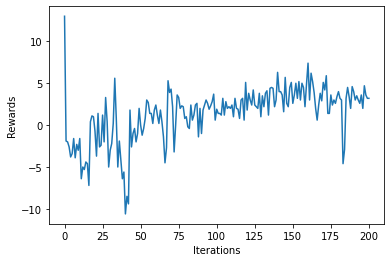

 20%|███████████████▍                                                             | 2012/10000 [03:11<13:23,  9.94it/s]

Mean Reward = 4.2
0


 20%|███████████████▌                                                             | 2022/10000 [03:12<12:40, 10.49it/s]

Mean Reward = 4.2
0


 20%|███████████████▌                                                             | 2026/10000 [03:12<12:50, 10.34it/s]

Updated Weights


 20%|███████████████▋                                                             | 2032/10000 [03:13<12:48, 10.36it/s]

Mean Reward = 3.4
0


 20%|███████████████▋                                                             | 2042/10000 [03:14<12:35, 10.54it/s]

Mean Reward = 3.2
0


 21%|███████████████▊                                                             | 2052/10000 [03:15<12:20, 10.73it/s]

Updated Weights
Mean Reward = 4.8
0


 21%|███████████████▉                                                             | 2062/10000 [03:15<12:16, 10.77it/s]

Mean Reward = 3.0
0


 21%|███████████████▉                                                             | 2072/10000 [03:16<12:09, 10.87it/s]

Mean Reward = 2.8
0


 21%|███████████████▉                                                             | 2076/10000 [03:17<12:22, 10.67it/s]

Updated Weights


 21%|████████████████                                                             | 2082/10000 [03:17<13:14,  9.97it/s]

Mean Reward = 4.4
0


 21%|████████████████                                                             | 2092/10000 [03:18<11:32, 11.42it/s]

Mean Reward = 5.0
2


 21%|████████████████▏                                                            | 2102/10000 [03:19<12:40, 10.38it/s]

Updated Weights
Mean Reward = 4.9
1


 21%|████████████████▎                                                            | 2112/10000 [03:20<12:04, 10.88it/s]

Mean Reward = 3.4
1


 21%|████████████████▎                                                            | 2122/10000 [03:21<12:24, 10.59it/s]

Mean Reward = 2.8
0


 21%|████████████████▍                                                            | 2128/10000 [03:21<10:02, 13.07it/s]

Updated Weights


 21%|████████████████▍                                                            | 2132/10000 [03:22<11:29, 11.42it/s]

Mean Reward = 5.5
2


 21%|████████████████▍                                                            | 2141/10000 [03:23<10:50, 12.09it/s]

Mean Reward = 4.0
1


 22%|████████████████▌                                                            | 2153/10000 [03:24<11:59, 10.90it/s]

Updated Weights
Mean Reward = 2.2
0


 22%|████████████████▋                                                            | 2163/10000 [03:24<11:32, 11.32it/s]

Mean Reward = 3.9
1


 22%|████████████████▋                                                            | 2171/10000 [03:25<11:51, 11.00it/s]

Mean Reward = 4.4
0


 22%|████████████████▊                                                            | 2177/10000 [03:26<12:10, 10.72it/s]

Updated Weights


 22%|████████████████▊                                                            | 2183/10000 [03:26<11:56, 10.91it/s]

Mean Reward = 3.0
0


 22%|████████████████▉                                                            | 2193/10000 [03:27<11:51, 10.97it/s]

Mean Reward = 4.2
0


 22%|████████████████▉                                                            | 2203/10000 [03:28<10:50, 11.98it/s]

Updated Weights
Mean Reward = 4.1
1


 22%|█████████████████                                                            | 2211/10000 [03:29<11:08, 11.64it/s]

Mean Reward = 4.0
1


 22%|█████████████████                                                            | 2221/10000 [03:30<11:55, 10.87it/s]

Mean Reward = 2.4
0


 22%|█████████████████▏                                                           | 2227/10000 [03:30<11:53, 10.90it/s]

Updated Weights


 22%|█████████████████▏                                                           | 2233/10000 [03:31<12:07, 10.68it/s]

Mean Reward = 2.8
0


 22%|█████████████████▎                                                           | 2241/10000 [03:31<10:23, 12.44it/s]

Mean Reward = 3.6
1


 23%|█████████████████▎                                                           | 2251/10000 [03:32<10:20, 12.50it/s]

Updated Weights
Mean Reward = 4.1
1


 23%|█████████████████▍                                                           | 2263/10000 [03:33<11:30, 11.21it/s]

Mean Reward = 3.6
0


 23%|█████████████████▌                                                           | 2273/10000 [03:34<10:31, 12.24it/s]

Mean Reward = 5.2
1


 23%|█████████████████▌                                                           | 2277/10000 [03:35<11:20, 11.34it/s]

Updated Weights


 23%|█████████████████▌                                                           | 2283/10000 [03:35<11:49, 10.87it/s]

Mean Reward = 2.8
0


 23%|█████████████████▋                                                           | 2291/10000 [03:36<11:57, 10.74it/s]

Mean Reward = 3.2
0


 23%|█████████████████▋                                                           | 2302/10000 [03:37<11:08, 11.52it/s]

Updated Weights
Mean Reward = 4.3
1


 23%|█████████████████▊                                                           | 2312/10000 [03:38<09:39, 13.26it/s]

Mean Reward = 4.3
2


 23%|█████████████████▉                                                           | 2322/10000 [03:38<10:40, 11.98it/s]

Mean Reward = 4.9
1


 23%|█████████████████▉                                                           | 2326/10000 [03:39<11:27, 11.16it/s]

Updated Weights


 23%|█████████████████▉                                                           | 2332/10000 [03:39<11:36, 11.01it/s]

Mean Reward = 3.4
0


 23%|██████████████████                                                           | 2342/10000 [03:40<11:39, 10.95it/s]

Mean Reward = 5.6
0


 24%|██████████████████                                                           | 2352/10000 [03:41<11:09, 11.42it/s]

Updated Weights
Mean Reward = 4.7
1


 24%|██████████████████▏                                                          | 2362/10000 [03:42<11:32, 11.03it/s]

Mean Reward = 3.4
0


 24%|██████████████████▎                                                          | 2372/10000 [03:43<11:54, 10.68it/s]

Mean Reward = 2.0
0


 24%|██████████████████▎                                                          | 2378/10000 [03:43<11:38, 10.92it/s]

Updated Weights


 24%|██████████████████▎                                                          | 2382/10000 [03:44<11:42, 10.85it/s]

Mean Reward = 2.2
0


 24%|██████████████████▍                                                          | 2393/10000 [03:45<10:41, 11.87it/s]

Mean Reward = 2.2
0


 24%|██████████████████▌                                                          | 2403/10000 [03:46<11:29, 11.01it/s]

Updated Weights
Mean Reward = 4.5
1


 24%|██████████████████▌                                                          | 2413/10000 [03:47<11:30, 10.99it/s]

Mean Reward = 4.0
0


 24%|██████████████████▋                                                          | 2423/10000 [03:48<11:41, 10.80it/s]

Mean Reward = 2.4
0


 24%|██████████████████▋                                                          | 2427/10000 [03:48<10:14, 12.33it/s]

Updated Weights


 24%|██████████████████▋                                                          | 2431/10000 [03:48<11:02, 11.43it/s]

Mean Reward = 4.5
1


 24%|██████████████████▊                                                          | 2443/10000 [03:49<11:24, 11.03it/s]

Mean Reward = 3.2
0


 25%|██████████████████▉                                                          | 2453/10000 [03:50<10:09, 12.39it/s]

Updated Weights
Mean Reward = 3.6
0


 25%|██████████████████▉                                                          | 2462/10000 [03:51<10:19, 12.17it/s]

Mean Reward = 6.1
2


 25%|███████████████████                                                          | 2472/10000 [03:52<11:06, 11.30it/s]

Mean Reward = 4.4
0


 25%|███████████████████                                                          | 2478/10000 [03:52<11:15, 11.13it/s]

Updated Weights


 25%|███████████████████                                                          | 2482/10000 [03:53<11:33, 10.85it/s]

Mean Reward = 2.8
0


 25%|███████████████████▏                                                         | 2492/10000 [03:54<10:49, 11.57it/s]

Mean Reward = 3.9
1


 25%|███████████████████▏                                                         | 2499/10000 [03:54<10:05, 12.38it/s]

Updated Weights
Mean Reward = 6.0
2


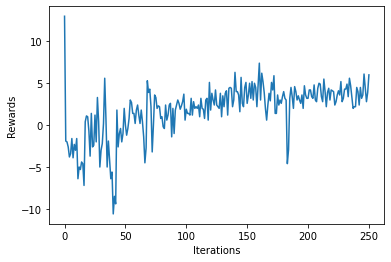

 25%|███████████████████▎                                                         | 2511/10000 [03:55<10:16, 12.14it/s]

Mean Reward = 5.1
1


 25%|███████████████████▍                                                         | 2524/10000 [03:56<09:30, 13.09it/s]

Mean Reward = 4.6
1


 25%|███████████████████▍                                                         | 2526/10000 [03:57<10:24, 11.97it/s]

Updated Weights


 25%|███████████████████▍                                                         | 2532/10000 [03:57<11:03, 11.26it/s]

Mean Reward = 4.3
1


 25%|███████████████████▌                                                         | 2542/10000 [03:58<11:30, 10.79it/s]

Mean Reward = 4.0
0


 26%|███████████████████▋                                                         | 2552/10000 [03:59<10:46, 11.52it/s]

Updated Weights
Mean Reward = 5.0
1


 26%|███████████████████▋                                                         | 2562/10000 [04:00<11:11, 11.08it/s]

Mean Reward = 2.8
0


 26%|███████████████████▊                                                         | 2573/10000 [04:01<10:40, 11.60it/s]

Mean Reward = 3.2
1


 26%|███████████████████▊                                                         | 2577/10000 [04:01<11:01, 11.21it/s]

Updated Weights


 26%|███████████████████▊                                                         | 2581/10000 [04:01<11:38, 10.63it/s]

Mean Reward = 3.0
0


 26%|███████████████████▉                                                         | 2591/10000 [04:02<11:47, 10.47it/s]

Mean Reward = 2.6
0


 26%|████████████████████                                                         | 2602/10000 [04:04<14:28,  8.52it/s]

Updated Weights
Mean Reward = 4.8
0


 26%|████████████████████                                                         | 2612/10000 [04:05<16:26,  7.49it/s]

Mean Reward = 3.4
0


 26%|████████████████████▏                                                        | 2622/10000 [04:06<16:59,  7.24it/s]

Mean Reward = 4.4
0


 26%|████████████████████▏                                                        | 2627/10000 [04:07<16:55,  7.26it/s]

Updated Weights


 26%|████████████████████▎                                                        | 2632/10000 [04:08<15:46,  7.79it/s]

Mean Reward = 4.7
1


 26%|████████████████████▎                                                        | 2642/10000 [04:09<15:32,  7.89it/s]

Mean Reward = 4.0
1


 27%|████████████████████▍                                                        | 2652/10000 [04:10<18:21,  6.67it/s]

Updated Weights
Mean Reward = 3.8
1


 27%|████████████████████▍                                                        | 2662/10000 [04:12<16:12,  7.54it/s]

Mean Reward = 3.4
0


 27%|████████████████████▌                                                        | 2672/10000 [04:13<16:25,  7.43it/s]

Mean Reward = 3.2
0


 27%|████████████████████▌                                                        | 2677/10000 [04:14<15:45,  7.75it/s]

Updated Weights


 27%|████████████████████▋                                                        | 2682/10000 [04:14<16:11,  7.53it/s]

Mean Reward = -1.0
0


 27%|████████████████████▋                                                        | 2692/10000 [04:16<14:11,  8.59it/s]

Mean Reward = 3.5
2


 27%|████████████████████▊                                                        | 2702/10000 [04:17<15:08,  8.04it/s]

Updated Weights
Mean Reward = 3.8
0


 27%|████████████████████▉                                                        | 2712/10000 [04:18<15:05,  8.05it/s]

Mean Reward = 5.8
0


 27%|████████████████████▉                                                        | 2722/10000 [04:19<15:25,  7.87it/s]

Mean Reward = 3.4
0


 27%|████████████████████▉                                                        | 2727/10000 [04:20<15:07,  8.02it/s]

Updated Weights


 27%|█████████████████████                                                        | 2732/10000 [04:21<14:42,  8.24it/s]

Mean Reward = 5.6
1


 27%|█████████████████████                                                        | 2742/10000 [04:22<14:58,  8.08it/s]

Mean Reward = 4.2
0


 28%|█████████████████████▏                                                       | 2752/10000 [04:23<13:15,  9.11it/s]

Updated Weights
Mean Reward = 4.2
1


 28%|█████████████████████▎                                                       | 2762/10000 [04:24<15:15,  7.90it/s]

Mean Reward = 2.8
0


 28%|█████████████████████▎                                                       | 2772/10000 [04:25<14:43,  8.18it/s]

Mean Reward = 2.9
1


 28%|█████████████████████▍                                                       | 2777/10000 [04:26<14:30,  8.30it/s]

Updated Weights


 28%|█████████████████████▍                                                       | 2782/10000 [04:27<15:17,  7.87it/s]

Mean Reward = 3.4
0


 28%|█████████████████████▍                                                       | 2792/10000 [04:28<13:55,  8.62it/s]

Mean Reward = 4.0
1


 28%|█████████████████████▌                                                       | 2801/10000 [04:29<15:29,  7.74it/s]

Updated Weights
Mean Reward = 5.1
1


 28%|█████████████████████▋                                                       | 2812/10000 [04:31<15:29,  7.73it/s]

Mean Reward = 2.4
0


 28%|█████████████████████▋                                                       | 2822/10000 [04:32<14:52,  8.04it/s]

Mean Reward = 3.4
1


 28%|█████████████████████▊                                                       | 2827/10000 [04:32<14:55,  8.01it/s]

Updated Weights


 28%|█████████████████████▊                                                       | 2832/10000 [04:33<17:02,  7.01it/s]

Mean Reward = 3.7
1


 28%|█████████████████████▉                                                       | 2842/10000 [04:34<15:49,  7.54it/s]

Mean Reward = 2.8
0


 29%|█████████████████████▉                                                       | 2852/10000 [04:36<15:35,  7.64it/s]

Updated Weights
Mean Reward = 2.0
0


 29%|██████████████████████                                                       | 2862/10000 [04:37<15:02,  7.91it/s]

Mean Reward = 3.8
0


 29%|██████████████████████                                                       | 2872/10000 [04:38<15:09,  7.84it/s]

Mean Reward = 1.8
0


 29%|██████████████████████▏                                                      | 2877/10000 [04:39<14:56,  7.94it/s]

Updated Weights


 29%|██████████████████████▏                                                      | 2883/10000 [04:40<13:12,  8.98it/s]

Mean Reward = 3.0
0


 29%|██████████████████████▎                                                      | 2892/10000 [04:41<14:33,  8.14it/s]

Mean Reward = 5.8
1


 29%|██████████████████████▎                                                      | 2901/10000 [04:42<15:19,  7.72it/s]

Updated Weights
Mean Reward = 4.8
0


 29%|██████████████████████▍                                                      | 2912/10000 [04:44<18:09,  6.50it/s]

Mean Reward = 4.4
0


 29%|██████████████████████▍                                                      | 2922/10000 [04:45<17:51,  6.61it/s]

Mean Reward = 5.4
1


 29%|██████████████████████▌                                                      | 2927/10000 [04:46<16:57,  6.95it/s]

Updated Weights


 29%|██████████████████████▌                                                      | 2932/10000 [04:46<16:10,  7.28it/s]

Mean Reward = 5.3
2


 29%|██████████████████████▋                                                      | 2942/10000 [04:48<15:15,  7.71it/s]

Mean Reward = 3.2
0


 30%|██████████████████████▋                                                      | 2952/10000 [04:49<16:22,  7.17it/s]

Updated Weights
Mean Reward = 0.8
0


 30%|██████████████████████▊                                                      | 2962/10000 [04:50<15:13,  7.70it/s]

Mean Reward = 4.0
0


 30%|██████████████████████▉                                                      | 2972/10000 [04:51<13:20,  8.78it/s]

Mean Reward = 2.9
1


 30%|██████████████████████▉                                                      | 2977/10000 [04:52<14:43,  7.95it/s]

Updated Weights


 30%|██████████████████████▉                                                      | 2982/10000 [04:53<16:03,  7.29it/s]

Mean Reward = -3.0
0


 30%|███████████████████████                                                      | 2992/10000 [04:54<13:51,  8.42it/s]

Mean Reward = 4.9
1


 30%|███████████████████████                                                      | 3000/10000 [04:55<14:55,  7.81it/s]

Updated Weights
Mean Reward = 3.0
0


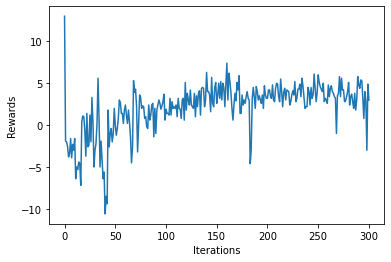

 30%|███████████████████████▏                                                     | 3012/10000 [04:57<17:50,  6.53it/s]

Mean Reward = 3.6
0


 30%|███████████████████████▎                                                     | 3022/10000 [04:58<16:38,  6.99it/s]

Mean Reward = 1.6
0


 30%|███████████████████████▎                                                     | 3027/10000 [04:59<16:52,  6.89it/s]

Updated Weights


 30%|███████████████████████▎                                                     | 3032/10000 [05:00<15:44,  7.38it/s]

Mean Reward = 2.4
0


 30%|███████████████████████▍                                                     | 3042/10000 [05:01<15:23,  7.54it/s]

Mean Reward = 3.8
0


 31%|███████████████████████▌                                                     | 3052/10000 [05:02<14:58,  7.73it/s]

Updated Weights
Mean Reward = 3.6
0


 31%|███████████████████████▌                                                     | 3062/10000 [05:04<14:49,  7.80it/s]

Mean Reward = 3.6
1


 31%|███████████████████████▋                                                     | 3073/10000 [05:05<15:47,  7.31it/s]

Mean Reward = 3.0
0


 31%|███████████████████████▋                                                     | 3077/10000 [05:06<17:48,  6.48it/s]

Updated Weights


 31%|███████████████████████▋                                                     | 3082/10000 [05:06<15:40,  7.36it/s]

Mean Reward = 3.4
1


 31%|███████████████████████▊                                                     | 3092/10000 [05:08<12:04,  9.54it/s]

Mean Reward = 5.0
2


 31%|███████████████████████▉                                                     | 3102/10000 [05:09<15:17,  7.52it/s]

Updated Weights
Mean Reward = 5.7
2


 31%|███████████████████████▉                                                     | 3103/10000 [05:09<14:41,  7.82it/s]

In [ ]:
rewards = []
mean_rewards = []
max_steps = 40
reached = 0
for epoch in tqdm(range(10000)):
    done = False
    episode_reward = 0
    step = 0
    start, dest = env.give_start_dest()
#     start = np.array([0.1,0.1])
#     dest = np.array([0.1,0.3])
    state = [start[0], start[1], dest[0], dest[1]]
    while not done and step<max_steps:
        state = np.array(state)
        next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
        state = next_state
        episode_reward+=reward
        step+=1
        if done:
            reached+=1
            
    if epoch>50:
        user_agent.train()
#         mod_agent.train()
    
    if epoch>50 and epoch%25==0:
        user_agent.target_model.set_weights(user_agent.model.get_weights())
#         mod_agent.target_model.set_weights(mod_agent.model.get_weights())
        print('Updated Weights')
        
    
    if epoch>50 and epoch%50==0:
        mod_agent.epsilon*=0.9
        user_agent.epsilon*=0.9
#         print(user_agent.replay_buffer.state_history[5])
#         print(user_agent.replay_buffer.action_history[5])
#         print(user_agent.replay_buffer.rewards_history[5])
#         print(user_agent.replay_buffer.next_state_history[5])

    mean_rewards.append(episode_reward)
    if epoch%10==0 and epoch:
        rewards.append(np.mean(mean_rewards))
        mean_rewards = []
        print(f'Mean Reward = {rewards[-1]}')
        print(reached)
        reached = 0
        
    if epoch%500==0 and epoch:
        plt.plot(rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.show()
    

In [ ]:
user_agent.model(np.array([[0.1, 0.1, 0.1 , 0.3]]))

In [ ]:
mod_agent.model(np.array([[0, 1, 0, 0, 1, 0.3]]))